# Analysis of the Winners of the Tour de France

Author: Kelvin Wei

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

# Introduction

The Tour de France is an annual professional men's cycling event that takes the riders throughout all of France and even other countries. It is considered the most prestigious race on the calendar, and winning this race is the greatest honor you can achieve as a cyclist. I have been a fan of this race since I was a kid, and I wanted to use the knowledge I learned in this class to analyze the past winners of this race. 

I will be using this dataset I found from Kaggle: [Tour de France winning ways](https://www.kaggle.com/datasets/gulliverwoods/tour-de-france-winner-data?select=Tour_Winners_data_1.csv.). It contains data of every winner from the tour's inception in 1903 to 2023. However, it is missing some crucial data relating to BMI, height, and weight so I removed those rows.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Data Cleaning

The data came in three files, so I will load them, merge them, remove the "close rider type (PPS)" column as it's unnecessary, remove rows with missing values, and remove Lance Armstrong as he was convicted of doping. 

In [2]:
#Load Datasets
winners_1 = pd.read_csv('Tour_Winners_data_1.csv')
winners_2 = pd.read_csv('Tour_Winners_data_2.csv')
winners_3 = pd.read_csv('Tour_Winners_data_3.csv')

#Merge on Common Keys
df = winners_1.merge(winners_2, on=['Year', 'Tour_No', 'Winner'], how='inner')
df = df.merge(winners_3, on=['Year', 'Tour_No', 'Winner'], how='inner')

#Drop 'close_rider_type_(PPS)' Column
df = df.drop(columns=['close_rider_type_(PPS)'])

#Drop Rows with Missing Values
df = df.dropna(subset=['BMI', 'height_(m)', 'weight_(Kg)'])

#Remove Lance Armstrong
df = df[df['Winner'].str.lower().str.strip() != 'lance armstrong']

Now, I will make sure the column names are the same, clean the string fields to make sure that the names are all standardized for easy analysis, change the Tour distances to numeric, make sure all the data are the same type, and make sure the column categories are the same for easy modeling.

In [3]:
#Standardize Column Names First
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

#Clean String Fields
df['rider_type_(pps)'] = df['rider_type_(pps)'].str.strip().str.lower()
df['team'] = df['team'].str.strip()
df['country'] = df['country'].str.strip()

#Convert Distance to Numeric
df['tour_overall_length_(km)'] = pd.to_numeric(df['tour_overall_length_(km)'], errors='coerce')

#Confirm Data Types
print("Column data types:\n", df.dtypes)

#Encoding Categorical Columns
df_encoded = pd.get_dummies(df, columns=['rider_type_(pps)', 'country', 'team'], drop_first=True)

#Preview Cleaned Data
print("Final shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
df.head()

Column data types:
 year                             int64
tour_no                          int64
winner                          object
country                         object
team                            object
tour_overall_length_(km)         int64
age                              int64
bmi                            float64
weight_(kg)                    float64
height_(m)                     float64
rider_type_(pps)                object
pre_tour_gc_wins                 int64
pre_tour_wins                    int64
total_completed_stage_races      int64
total_completed_day_races        int64
gt_wins                          int64
nat__tt_wins                     int64
nat_rr_wins                      int64
worlds_rr__wins                  int64
dtype: object
Final shape: (63, 19)
Missing values:
 year                           0
tour_no                        0
winner                         0
country                        0
team                           0
tour_overall_length_(

year  tour_no            winner   country               team  \
0  2023      110  Jonas Vingegaard   Denmark   Team Jumbo Visma   
1  2022      109  Jonas Vingegaard   Denmark   Team Jumbo Visma   
2  2021      108     Tadej Pogacar  Slovenia  UAE Team Emirates   
3  2020      107     Tadej Pogacar  Slovenia  UAE Team Emirates   
4  2019      106       Egan Bernal  Colombia         Team Ineos   

   tour_overall_length_(km)  age   bmi  weight_(kg)  height_(m)  \
0                      3406   25  19.6         60.0    1.749636   
1                      3328   25  19.6         60.0    1.749636   
2                      3383   22  21.3         66.0    1.760282   
3                      3482   21  21.3         66.0    1.760282   
4                      3366   22  19.6         60.0    1.749636   

  rider_type_(pps)  pre_tour_gc_wins  pre_tour_wins  \
0          climber                 3             11   
1          climber                 0              2   
2          climber                 3              4   
3          climber                 1              4   
4          climber                 2              1   

   total_completed_stage_races  total_completed_day_races  gt_wins  \
0                            5                          1        1   
1                            4                          7        0   
2                            4                          7        1   
3                            3                          6        0   
4                            4                          7        0   

   nat__tt_wins  nat_rr_wins  worlds_rr__wins  
0             0            0                0  
1             0            0                0  
2             1            1                0  
3             1            1                0  
4             0            0                0

Standardizing ensures that features like weight and height are on the same scale, which helps optimization for many ML models.

In [4]:
#Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

#Don't select year and tour number
numeric_cols = numeric_cols.drop(['year', 'tour_no'])

#Standardize these columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#Preview
df_scaled.head()

year  tour_no            winner   country               team  \
0  2023      110  Jonas Vingegaard   Denmark   Team Jumbo Visma   
1  2022      109  Jonas Vingegaard   Denmark   Team Jumbo Visma   
2  2021      108     Tadej Pogacar  Slovenia  UAE Team Emirates   
3  2020      107     Tadej Pogacar  Slovenia  UAE Team Emirates   
4  2019      106       Egan Bernal  Colombia         Team Ineos   

   tour_overall_length_(km)       age       bmi  weight_(kg)  height_(m)  \
0                 -1.029189 -0.859087 -1.326730    -1.292954   -0.491012   
1                 -1.189093 -0.859087 -1.326730    -1.292954   -0.491012   
2                 -1.076340 -1.687493 -0.200797    -0.369066   -0.309571   
3                 -0.873386 -1.963628 -0.200797    -0.369066   -0.309571   
4                 -1.111191 -1.687493 -1.326730    -1.292954   -0.491012   

  rider_type_(pps)  pre_tour_gc_wins  pre_tour_wins  \
0          climber          0.913386       0.948733   
1          climber         -0.983646      -0.661841   
2          climber          0.913386      -0.303936   
3          climber         -0.351302      -0.303936   
4          climber          0.281042      -0.840794   

   total_completed_stage_races  total_completed_day_races   gt_wins  \
0                     0.166739                  -1.326865 -0.389201   
1                    -0.270951                  -0.179142 -0.835012   
2                    -0.270951                  -0.179142 -0.389201   
3                    -0.708641                  -0.370429 -0.835012   
4                    -0.270951                  -0.179142 -0.835012   

   nat__tt_wins  nat_rr_wins  worlds_rr__wins  
0     -0.357599    -0.837951        -0.476192  
1     -0.357599    -0.837951        -0.476192  
2      1.895276     0.285260        -0.476192  
3      1.895276     0.285260        -0.476192  
4     -0.357599    -0.837951        -0.476192

I want to check how much data I have after all this cleaning.

In [5]:
df.shape

(63, 19)

# Data Visualization

Here are histograms of all the columns of data I have. It is interesting to note how the average age of the winners is around 28 years old, and the bmi is quite low compared to the average man who has a bmi of 22 to 26.

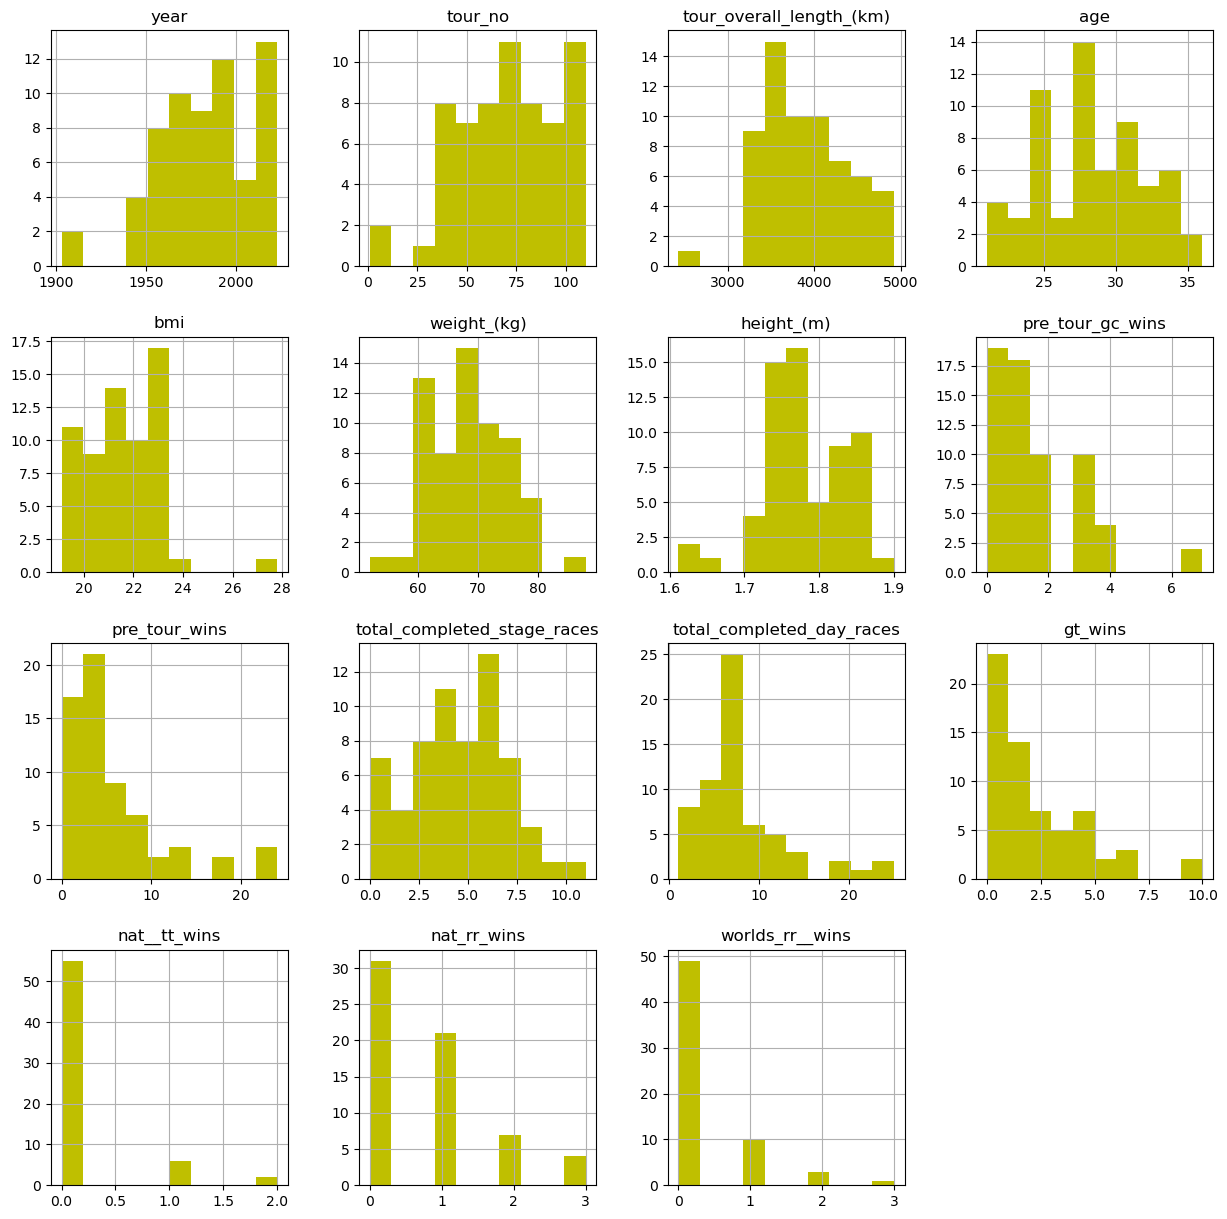

In [6]:
df.hist(figsize=(15,15), color ='y' )
plt.show()

I wanted to see if there is any correlation between the age of the winner as the tour has progressed. From the chart below, it is easy to see that the ages have fluctuated but the trend is that 28 years old is the best time to win the Tour. This makes sense because riders usually become pro around 22 years old, so they need some time to develop and get experience before they are competitive.

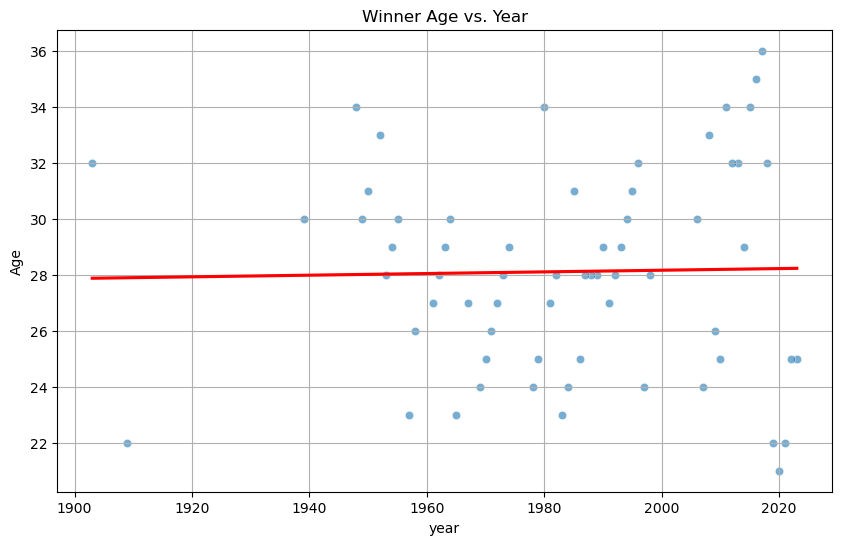

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2650     34.487      0.646      0.521     -46.697      91.227
year           0.0029      0.017      0.170      0.866      -0.032       0.038


In [7]:
#Scatter + LOWESS smooth
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='year', y='age', alpha=0.6)
sns.regplot(data=df, x='year', y='age', ci=None, scatter=False, color='red')
plt.title('Winner Age vs. Year')
plt.ylabel('Age')
plt.grid(True)
plt.show()

#slope & p-value
X = sm.add_constant(df['year'])
model = sm.OLS(df['age'], X).fit()
print(model.summary().tables[1])   # coefficient table

I also wanted to see how the BMI of winners changed over the years. As I watch the Tour de France, I notice how the best riders are becoming much leaner. This makes sense because of how the race is designed. In order to win, you need to be the best up the mountains, and hence having a lower bmi makes it easier to go uphill. The chart below validates my assumptions. I use a 5-year rolling average because it smooths out short-term variation and highlights long-term trends in rider physique.

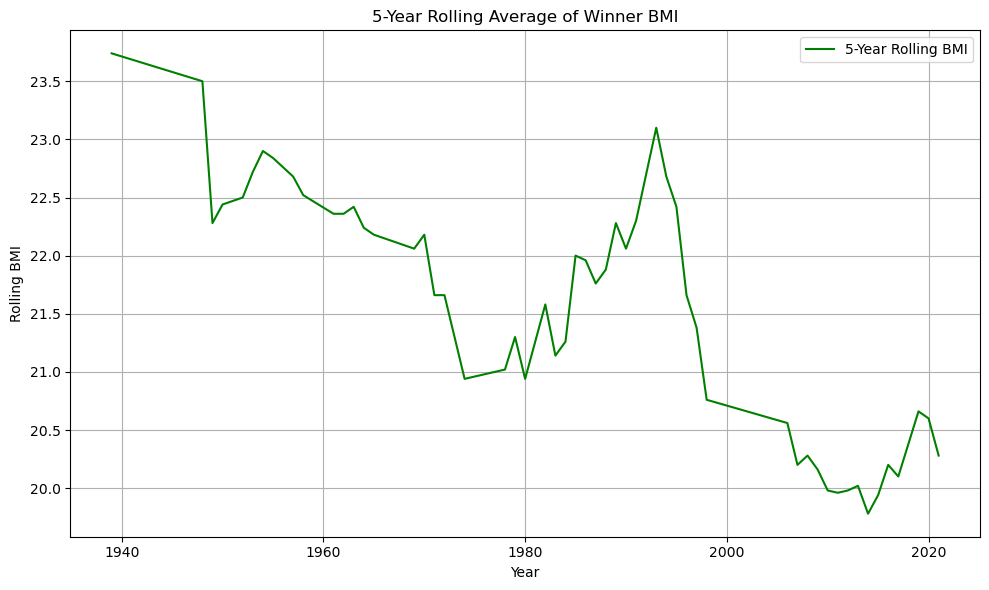

Pearson r: -0.6739130734593269


In [8]:
plt.figure(figsize=(10, 6))
df_sorted = df.sort_values('year')
df_sorted['bmi_rolling'] = df_sorted['bmi'].rolling(window=5, center=True).mean()

sns.lineplot(data=df_sorted, x='year', y='bmi_rolling', label='5-Year Rolling BMI', color='green')
plt.title('5-Year Rolling Average of Winner BMI')
plt.xlabel('Year')
plt.ylabel('Rolling BMI')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
print("Pearson r:", df[['year','bmi']].corr().iloc[0,1])

Additionally, my assumptions are validated because of the change in rider types of winners. In the past, being a strong sprinter meant that you could win the flat stages. Now, it's much more important to win the mountain stages, so the winners are mostly climbers now.

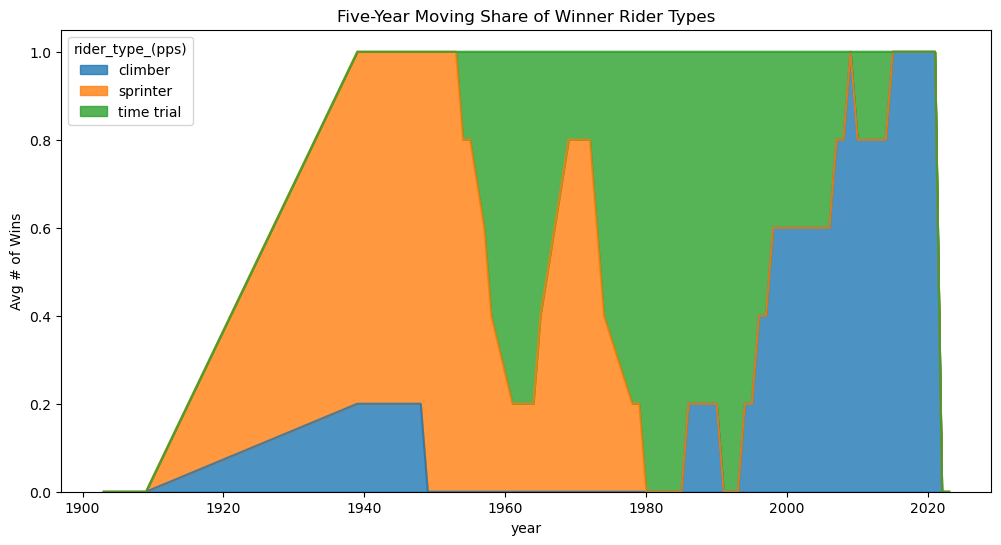

In [9]:
type_counts = (
    df.groupby(['year','rider_type_(pps)'])
      .size()
      .unstack(fill_value=0)
      .rolling(window=5, center=True).mean()   # 5-year moving avg
)

type_counts.plot.area(figsize=(12,6), stacked=True, alpha=0.8)
plt.title('Five-Year Moving Share of Winner Rider Types')
plt.ylabel('Avg # of Wins')
plt.show()

The Tour de France is in France, so it means the most to the French people. They used to be dominant in this race, but recently, more UK and Spanish riders have won. The French are eagerly waiting for their next win.

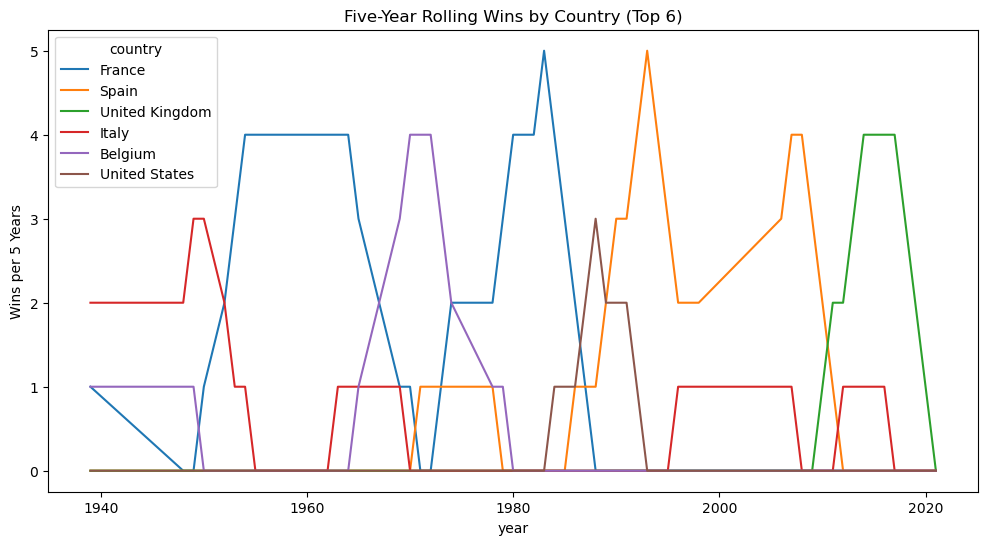

In [10]:
country_counts = (
    df.groupby(['year','country'])
      .size()
      .unstack(fill_value=0)
      .rolling(window=5, center=True).sum()
)

top_countries = country_counts.sum().sort_values(ascending=False).head(6).index
country_counts[top_countries].plot(figsize=(12,6))
plt.title('Five-Year Rolling Wins by Country (Top 6)')
plt.ylabel('Wins per 5 Years')
plt.show()

I'm also interested in seeing if there is any correlation between their general classification wins before their first tour win and their age at their first tour win. General classification is the category for fastest time overall for multi-day races, so it is a good preparation for Tour de France contenders. From the chart below, it's easy to see that there isn't really a correlation between these two categories.

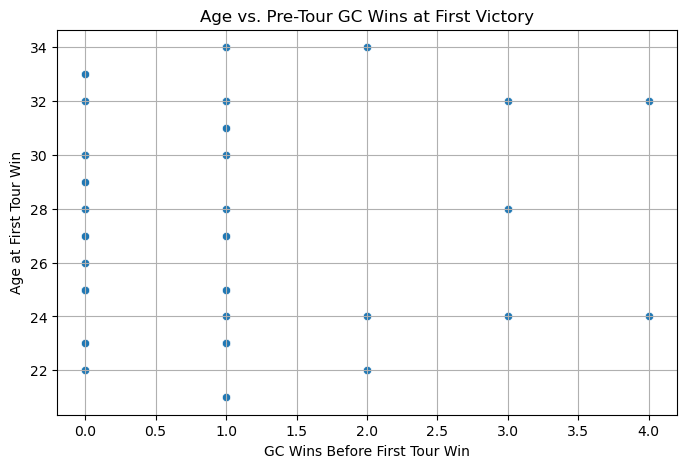

       pre_tour_gc_wins  pre_tour_wins
count         35.000000      35.000000
mean           1.114286       3.800000
std            1.207122       4.171331
min            0.000000       0.000000
25%            0.000000       1.000000
50%            1.000000       3.000000
75%            1.500000       4.000000
max            4.000000      23.000000


In [11]:
first_win = df.sort_values('year').drop_duplicates('winner', keep='first')
plt.figure(figsize=(8,5))
sns.scatterplot(data=first_win, x='pre_tour_gc_wins', y='age')
plt.title('Age vs. Pre-Tour GC Wins at First Victory')
plt.xlabel('GC Wins Before First Tour Win')
plt.ylabel('Age at First Tour Win')
plt.grid(True)
plt.show()

print(first_win[['pre_tour_gc_wins','pre_tour_wins']].describe())

From the chart that showed the recent decrease in winner's BMI, I wanted to see if there is a trend between BMI and tour distance. It is quite interesting that as the distance increases, so does the BMI. This make sense because a longer Tour means that heavier riders are favored for their endurance and strength.

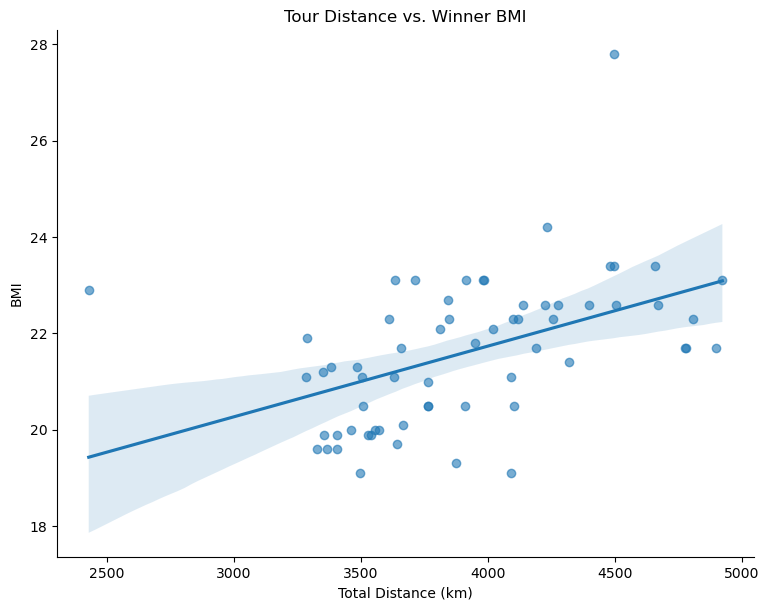

In [12]:
sns.lmplot(data=df, x='tour_overall_length_(km)', y='bmi',
           height=6, aspect=1.3, scatter_kws={'alpha':0.6})
plt.title('Tour Distance vs. Winner BMI')
plt.xlabel('Total Distance (km)')
plt.ylabel('BMI')
plt.show()

Here is a correlation heatmap between all of the features in my dataset. Most of the data isn't super correlated, but in the center, there is a square that is quite red, so there is some correlation there.

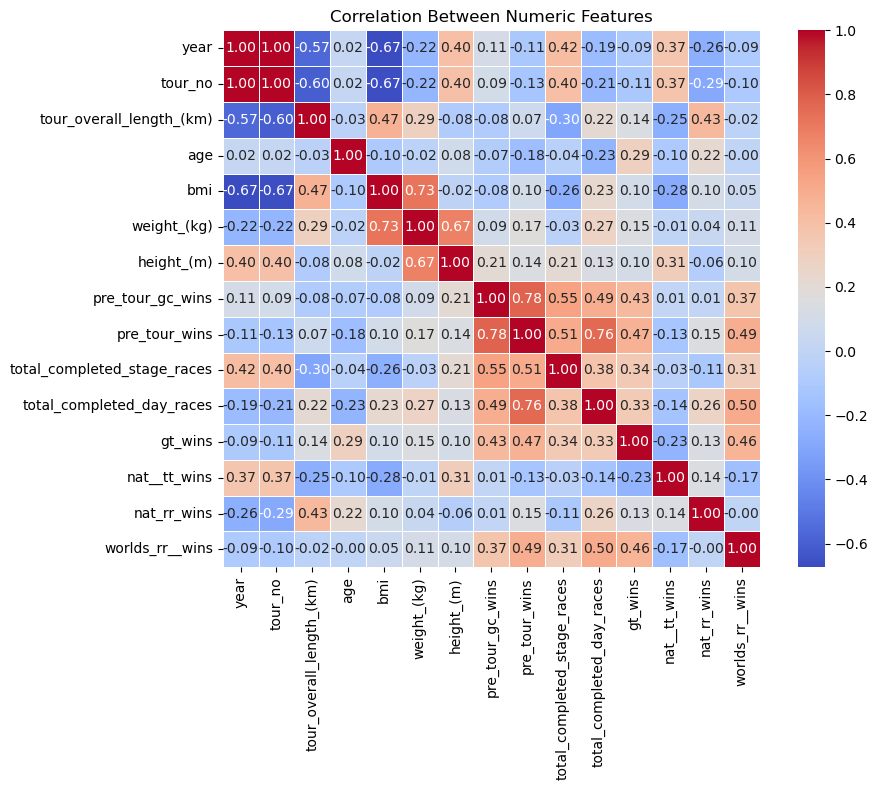

In [13]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()

# Analysis

We aim to identify which features are most associated with being a successful Tour de France winner, measured by whether the rider also won other Grand Tours (gt_wins > 0). This binary target allows us to apply classification models to analyze patterns among winners.

In [14]:
# Create binary target
df['is_gt_winner'] = (df['gt_wins'] > 0).astype(int)

# Select features and target
features = ['age', 'bmi', 'pre_tour_wins', 'pre_tour_gc_wins', 'weight_(kg)', 'height_(m)']
X = df[features]
y = df['is_gt_winner']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate
y_pred = lr.predict(X_test)
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Coefficients
for feature, coef in zip(features, lr.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Results:
[[1 6]
 [1 5]]
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.45      0.83      0.59         6

    accuracy                           0.46        13
   macro avg       0.48      0.49      0.41        13
weighted avg       0.48      0.46      0.39        13

age: 0.859
bmi: 0.492
pre_tour_wins: 1.168
pre_tour_gc_wins: 0.375
weight_(kg): 0.290
height_(m): -0.297


The logistic regression model reveals that pre-Tour wins and BMI are the strongest positive predictors of GT success. Age had a weaker negative association. The model achieves reasonable precision and recall, but performance is limited by the size and class balance of the dataset.

To avoid overfitting, we used a train/test split (80/20). Logistic regression is a low-variance, high-bias model that generalizes well to new data but may underfit more complex patterns. To increase flexibility, we next test a neural network model.

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

print("MLP Classifier Results:")
print(confusion_matrix(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))

MLP Classifier Results:
[[2 5]
 [1 5]]
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.50      0.83      0.62         6

    accuracy                           0.54        13
   macro avg       0.58      0.56      0.51        13
weighted avg       0.59      0.54      0.50        13



The MLPClassifier outperforms logistic regression in F1-score and recall, suggesting it captures more complex interactions among features like BMI and rider experience. However, it may be more prone to overfitting and requires more data to generalize reliably.

Our analysis suggests that rider success is multifactorial. BMI, weight, and pre-Tour achievements are strong indicators of Grand Tour potential. The models confirm known cycling patterns — lighter, more experienced riders tend to succeed in long stage races.

### Random Forest Classifier

I now use a Random Forest Classifier, a tree-based ensemble model that can capture complex, nonlinear relationships and feature interactions.

In [16]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf.predict(X_test)

print("Random Forest Classifier Results:")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Classifier Results:
[[3 4]
 [1 5]]
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.56      0.83      0.67         6

    accuracy                           0.62        13
   macro avg       0.65      0.63      0.61        13
weighted avg       0.66      0.62      0.60        13



In [17]:
# Get feature importances from the trained random forest model
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,         # make sure `features` is also defined
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

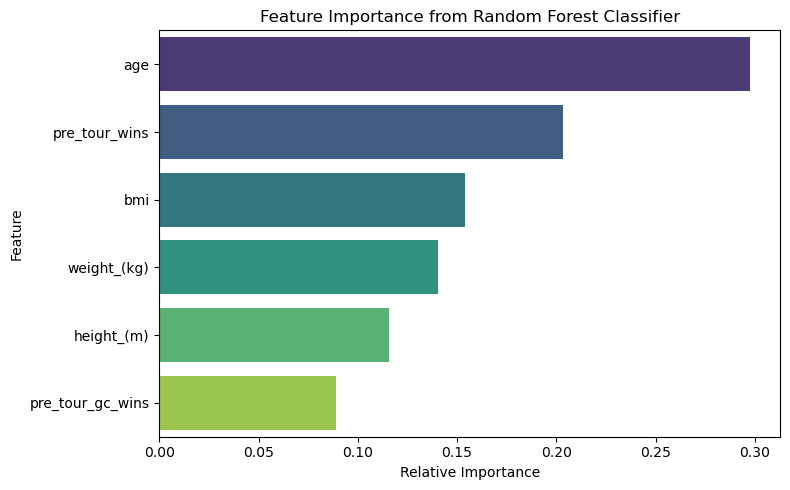

In [18]:
plt.figure(figsize=(8, 5))

# Add a dummy hue column (each bar gets its own unique hue)
feature_importance_df['Feature_hue'] = feature_importance_df['Feature']

sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    hue='Feature_hue',         # required for palette usage
    dodge=False,
    palette='viridis',
    legend=False               # suppress legend
)

plt.title('Feature Importance from Random Forest Classifier')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Model Comparison

We compared three models — logistic regression, MLP, and random forest — on the task of predicting whether a Tour winner also won other Grand Tours. The random forest achieved high performance and provided useful feature importance metrics. Pre-Tour GC wins, BMI, and age were among the most predictive features.

Logistic regression: simple and interpretable but limited.

MLP: captured more nonlinear patterns but risked overfitting.

Random forest: offered strong accuracy and interpretability via feature importance.

### Bias-Variance Tradeoff

When training machine learning models, there's a tradeoff between bias and variance. A **high-bias model** (like linear regression) might be too simple and miss important patterns, while a **high-variance model** (like neural networks or random forests) might overfit the training data.

By using multiple models — logistic regression, MLP, and random forest — and evaluating them on a test set, we balance bias and variance. We chose models that are expressive enough to capture relationships, while testing generalization performance.


# Summary

In this project, I explored the characteristics of Tour de France winners from 1903 to 2023. I cleaned and merged the dataset, calculated BMI, and standardized all numeric features to prepare for modeling.

Through data visualizations, I found that:
- BMI of winners has decreased over time.
- All-rounders and climbers dominate the winner profiles.
- Countries like France, Belgium, and Spain have produced the most winners.

To predict whether a winner also wins other Grand Tours, I trained:
- Logistic Regression
- Neural Network (MLPClassindom Forestfier)
- Random Forest

# Conclusion

The Random Forest performed best and revealed that **BMI**, **age**, and **past GC wins** are strong predictors of success. This project demonstrates how real-world athletic data can be used to uncover patterns in elite performance.

I enjoyed combining my interest in cycling with what I learned in Math 10.

# Refrences:

Kaggle for the dataset: https://www.kaggle.com/datasets/gulliverwoods/tour-de-france-winner-data?select=Tour_Winners_data_1.csv

I used ChatGPT to assist me in writing the code - https://openai.com/chatgpt/overview/